<a href="https://colab.research.google.com/github/MYRGETE/Proyecto-ML/blob/main/Proyecto_ML_Myriam_Gaete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Final – Calidad del Aire en Curicó**
Myriam Gaete
______________________________________________________

La contaminación del aire es uno de los mayores problemas que afecta a los países en casi cualquier parte del mundo. El incremento en las cantidades de gases y partículas potencialmente dañinas para la salud y el medio ambiente se ha constatado a escala mundial, y cada día es más obvio que la respuesta a estos
problemas se concentra en la búsqueda de soluciones inteligentes.
En Chile, por ley, se establece la obligación de desarrollar planes de descontaminación en áreas donde los niveles de contaminantes excedan sistemáticamente las normas ambientales, y planes de prevención donde dichas normas se encuentren en peligro de ser superadas [1].

El objetivo de esta investigación es estudiar y predecir la calidad del aire en la ciudad de Curicó mediante técnicas de Minería de datos. Para cumplir con estos objetivos


## **Metodología**
Para el desarrollo de este trabajo se trabajará con la metodología *Knowledge Discovery in Databases* (KDD). Esta metodología es un proceso automático en el que se combinan descubrimiento y análisis [2]. El proceso consiste en extraer patrones en forma de reglas o funciones, a partir de los datos, para que el usuario los analice [3]. A continuación se presenta una imagen de las etapas del modelo:




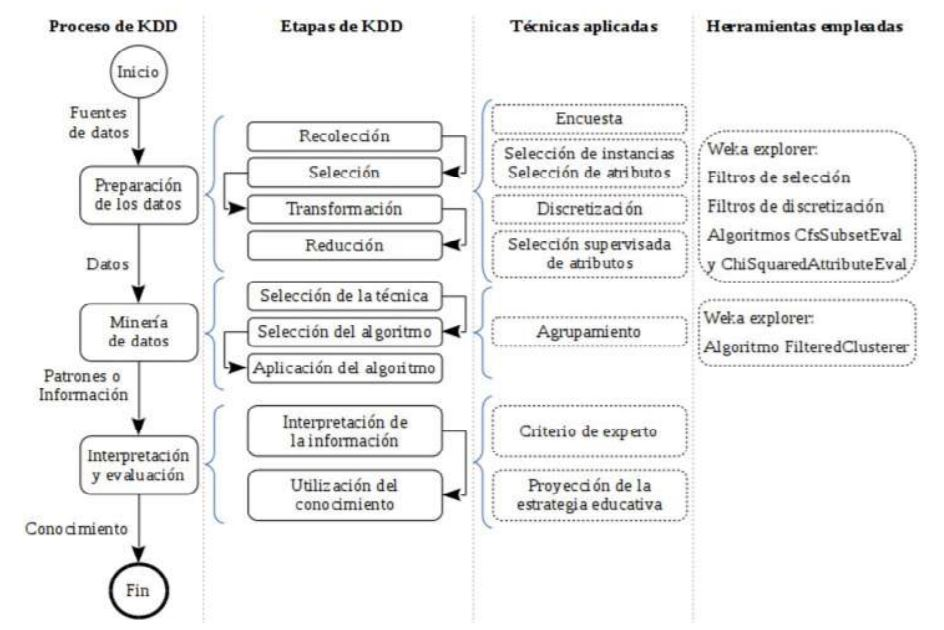

*Fuente: Aguila & Segredo [4]*


**Preprocesamiento de los datos:** La primera etapa de la metodología KDD tiene como propósito obtener las fuentes internas y externas de datos que sirven de base para el proceso de minería de ellos [5]. Luego de contar con los datos, se debe aplican operaciones matemáticas para asegurar la eliminación de datos ruidosos, datos nulos, datos duplicados [5]. 

**Minería de datos:** En la etapa de minería de datos se aplicarán las herramientas para realizar el pronóstico de la calidad del aíre de Curicó a través de un modelo Prophet [Link](https://facebook.github.io/prophet/). 

**Interpretación y evaluación:** Corresponde a la evaluación de los resultados por medio de métricas y simulación. En cuanto a las métricas de comparación de algoritmo, se usarán las siguientes: 

*   **MAE:** Error absoluto medio
*   **MSE:** Error cuadrático medio 
*   **R2:** Coeficiente de correlación
*   **U:** Coeficiente de desigualdad de Theil



## **Preparación de los Datos**

### **Datos**
La base de datos estudiada tiene las métricas de calidad del aire obtenidas del Sistema de Información Nacional de Calidad del Aire (SINCA) que presenta información de calidad de aire de todo el país, buscando mejorar gradualmente el conocimiento, la vigilancia y la gestión de la calidad del aire que respiramos [6]. La información corresponde a las mediciones de 07-07-2012 a 30-11-2021 realizadas cada una hora en la estación ubicada en la ciudad de Curicó [7]. -la base de datos cuenta con las siguientes columnas:

*   **Fecha**: corresponde al año, mes y día que se tomó la muestra en ese mismo orden.
*   **Hora**: corresponde a la hora y minutos en que se tomó la muestra en ese orden.
*   **Registros no validados (RNV)**: corresponde a la información recibida en línea, de forma automática, desde las estaciones de monitoreo que se encuentren conectadas al sistema [6].
*   **Registros preliminares (RP):** corresponden a datos validados en una primera instancia, efectuada por los operadores de la estación donde se corrigen los datos desfasados o se eliminan aquellos que corresponden a fallas o mantenciones como las calibraciones de los instrumentos [6].
*   **Registros oficiales (RO):** corresponden a datos validados previamente por los operadores de las estaciones, que pasan por un segundo proceso de validación por algún organismo estatal que tenga competencias sobre los datos [6].


A continuación se presenta el proceso de carga de los datos y la transformación de la fecha para ser reconocida como tal en el Dataframe de Python:


In [127]:
import pandas as pd
# Extracción de los datos
Link=("https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath=")
Datos = pd.read_csv(Link, sep=";",decimal=",")

#Cambio de nombre de las columnas
Datos.columns=['Time','Hour','RNV','RP','RO','v1'];

#Cambio el Formato de la fecha 
Datos['Time2']=pd.to_datetime(Datos['Time'],format="%y%m%d")
Datos['Hour2']=pd.to_datetime(Datos['Hour'].astype(str).str.zfill(4),format="%H%M")
Datos['Hour2'] = Datos['Hour2'].dt.strftime("%H:%M:%S")

#Guardar la fecha y hora de la muestra en la columna Fecha
Datos['Fecha'] = pd.to_datetime(Datos.pop('Time2')) + pd.to_timedelta(Datos.pop('Hour2'))

#Imprimir descripción de los datos
Datos.describe()



,Time,Hour,RNV,RP,RO,v1
count,82415.000000,82415.000000,57743.000000,16484.000000,2743.000000,0.0
mean,167732.544088,1150.013954,26.576942,24.837794,173.897907,NaN
std,27252.064658,692.215463,38.592488,34.566945,330.481939,NaN
min,120707.000000,0.000000,1.000000,1.000000,-9.276490,NaN
25%,141112.000000,600.000000,8.000000,9.000000,8.090000,NaN
50%,170320.000000,1200.000000,14.180000,14.000000,26.970000,NaN
75%,190726.000000,1750.000000,28.857050,25.000000,98.400000,NaN
max,211130.000000,2300.000000,612.000000,500.000000,1000.000000,NaN


### **Preprocesamiento y transformación de los datos**

Luego de realizar la carga de datos, se procede a analizar la información obtenida considerando las siguientes situaciones:

* **Cantidad de columnas:** Según los requerimientos del caso de estudios, solo podemos contar con dos columnas, una con la fecha y otra con el dato a analizar, por tanto se 
* **Datos faltantes o erróneos:** En tener datos faltantes o erróneos en la base de datos, estos valores se reemplazarán con el promedio de la columna en la base de datos. 

* **Análisis de las tendencias:** Considerando que estudiamos la cantidad de material particulados, se considera un dato erróneo a toda instancia que tenga un valor menor o igual a cero. En estos casos se reemplazará con el valor promedio de la columna.



**Cantidad de columnas:** Se comienza el análisis con la agrupación de la información.


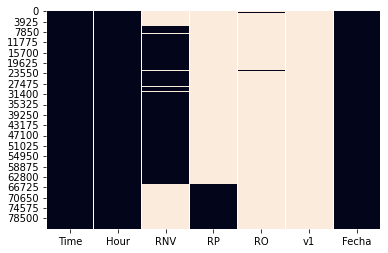

In [128]:
#Cantidad de columnas: Se comienza con la revisión de las columnas con registros (RNV, RP y RO)
import seaborn as sns
sns.heatmap(Datos.isnull(), cbar=False)

Como se puede apreciar en la gráfica anterior, en cada una de las instancias existe un valor de registro, por tanto, hacer una suma de las tres columnas asegura en la mayoría de las instancias tener a lo menos un dato. 

In [129]:
#Se agrupan las tres columnas en solo una columna
import numpy as np
Datos.iloc[:,2].fillna(0, inplace=True)
Datos.iloc[:,3].fillna(0, inplace=True)
Datos.iloc[:,4].fillna(0, inplace=True)
Datos['Registros'] = Datos.iloc[:,2]+Datos.iloc[:,3]+Datos.iloc[:,4]

#Para facilitar los calculos se crea una nueva base de datos solo con la Fecha y Registros
Datos2 = pd.DataFrame()
Datos2["Fecha"]=Datos["Fecha"]
Datos2["Registros"]=Datos["Registros"]

#del(Datos2['Time'])
#del(Datos2['Hour'])
#del(Datos2['RNV'])
#del(Datos2['RP'])
#del(Datos2['RO'])
#del(Datos2['v1'])
##del(Datos2['Fecha'])


**Datos faltantes o erróneos:** Luego de crear una nueva base de datos, se reemplazaran todos los datos faltantes y erróneos. Para esto, se imputaran todas las instancias con valores negativos o cero.

                    Fecha  Registros
0     2012-07-07 01:00:00        0.0
1     2012-07-07 02:00:00        0.0
2     2012-07-07 03:00:00        0.0
3     2012-07-07 04:00:00        0.0
4     2012-07-07 05:00:00        0.0
...                   ...        ...
82410 2021-11-30 19:00:00        3.0
82411 2021-11-30 20:00:00        7.0
82412 2021-11-30 21:00:00        7.0
82413 2021-11-30 22:00:00       11.0
82414 2021-11-30 23:00:00        7.0

[82415 rows x 2 columns]


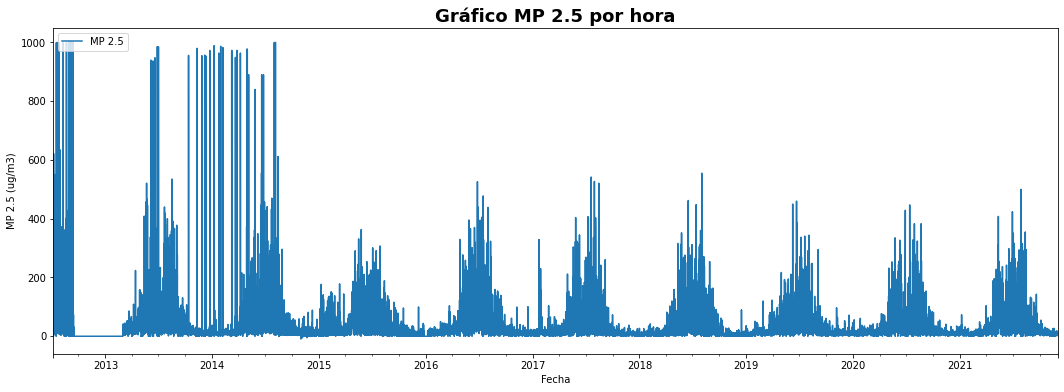

In [130]:
print(Datos2)
import matplotlib.pyplot as mplt
import seaborn as sbn
import matplotlib.pyplot as plt

media=Datos['Registros'].mean()
Datos.loc[Datos.Registros<=0,'Registros']=media

fig, ax = plt.subplots(figsize=(18,6))
Datos2.plot(x="Fecha", y="Registros", ax=ax, label="MP 2.5")
plt.legend(loc='upper left')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico MP 2.5 por hora",fontdict={'weight': 'bold','size': 18})

plt.savefig('Images/Gráfico MP 2.5 Curicó por hora.png')
plt.show();

El gráfico muestra que no existe una tendencia claro entre el 2012 y 2014. Dado este problema se agruparán las instancias de la base de datos por día, con el propósito de mejorar la tendencia de estos. 

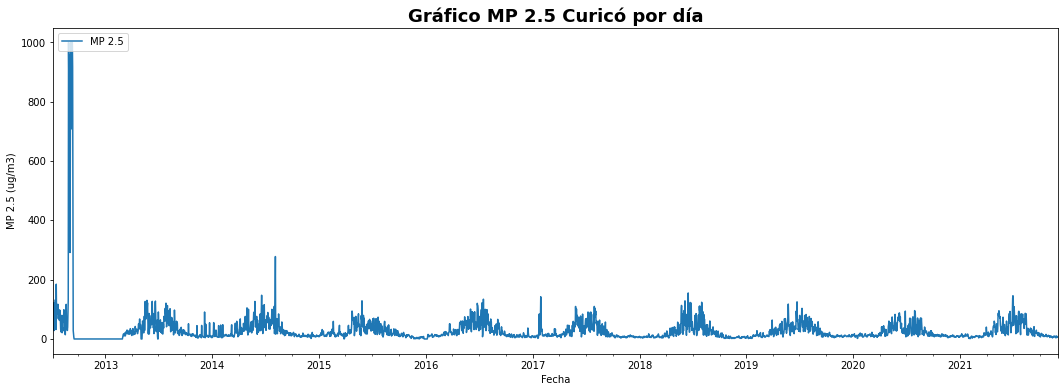

In [131]:
Datos3=Datos2
Datos3['Fecha2']=Datos['Time']
Datos3=Datos3.groupby(by="Fecha2").mean()
Datos3=Datos3.reset_index()
#print(Datos3)

Datos3["Fecha"]=pd.to_datetime(Datos3['Fecha2'],format="%y%m%d")
del(Datos3['Fecha2'])
Datos3 = Datos3[['Fecha',"Registros"]]
#print(Datos3)

fig, ax = plt.subplots(figsize=(18,6))
Datos3.plot(x="Fecha", y="Registros", ax=ax, label="MP 2.5")
plt.legend(loc='upper left')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico MP 2.5 Curicó por día",fontdict={'weight': 'bold','size': 18})

plt.savefig('Images/Gráfico MP 2.5 por día.png')
plt.show();

Se aprecia que al agrupar por día, se ve mejor la tendencia, pero se eliminaran las instancias del año 2012, por que aparentan ser datos atípicos. 

          Fecha  Registros
178  2013-01-01   0.000000
179  2013-01-02   0.000000
180  2013-01-03   0.000000
181  2013-01-04   0.000000
182  2013-01-05   0.000000
...         ...        ...
3429 2021-11-26   8.750000
3430 2021-11-27   7.000000
3431 2021-11-28   8.333333
3432 2021-11-29   7.875000
3433 2021-11-30   6.375000

[3256 rows x 2 columns]


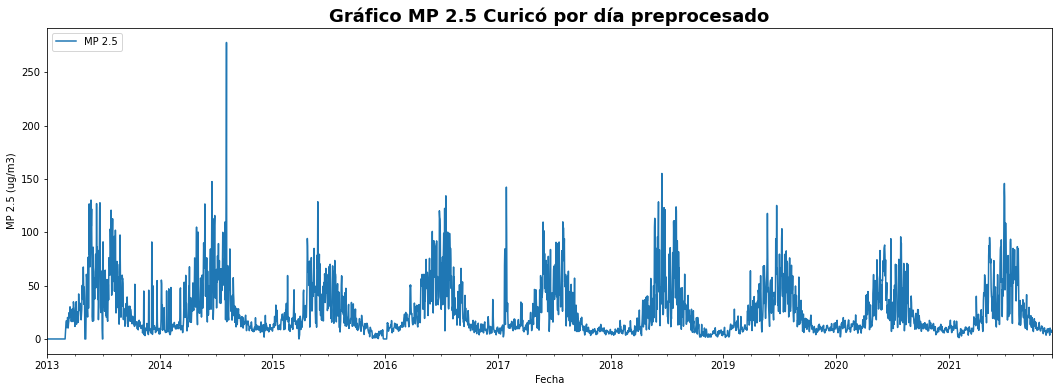

In [132]:
Datos3=Datos3.drop(range(0, 178, 1),axis=0)
print(Datos3)
fig, ax = plt.subplots(figsize=(18,6))
Datos3.plot(x="Fecha", y="Registros", ax=ax, label="MP 2.5")
plt.legend(loc='upper left')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico MP 2.5 Curicó por día preprocesado",fontdict={'weight': 'bold','size': 18})

plt.savefig('Images/Gráfico MP 2.5 por día preprocesado.png')
plt.show();


El resultado muestra una muy buena gráfica, por tanto, los datos se trabajarán de manera diaria y se eliminarán los datos del 2012.

## **Resultados**

Luego de realizar el análisis se comienza a evaluar la estacionalidad de los datos con los métodos estadísticos.

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # 12 months seasonality
model = "additive"

decomposition = seasonal_decompose(
    Datos3.set_index("Fecha").Registros.interpolate("linear"),
    freq=decompfreq)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

### **Tendencia**

La tendencia se define como un cambio a largo plazo que se produce en la
relación al nivel medio, o el cambio a largo plazo de la media [8]. En este caso, visualmente no se puede apreciar si existe o no una tendencia, por tanto, se usará el test estadístico Mann Kendall, considerando



*   **Ho=** Los datos presentan tendencia.
*   **H1=** Los datos no presentan tendencia


El resultado del Test muestra la presencia de una tendencia decreciente de los datos, y como el p-value es menor a un 5%, se rechaza la hipótesis nula y no se puede asegurar la existencia de una tendencia decreciente en los datos.


Mann_Kendall_Test(trend='decreasing', h=True, p=0.00012364679799725664, z=-3.838780711072997, Tau=-0.04487369648659971, s=-237792.0, var_s=3837109728.0, slope=-0.0009285051067780871, intercept=17.523442061281333)

 Resultados
 Tendencia: decreasing
 P-value: 0.00012364679799725664


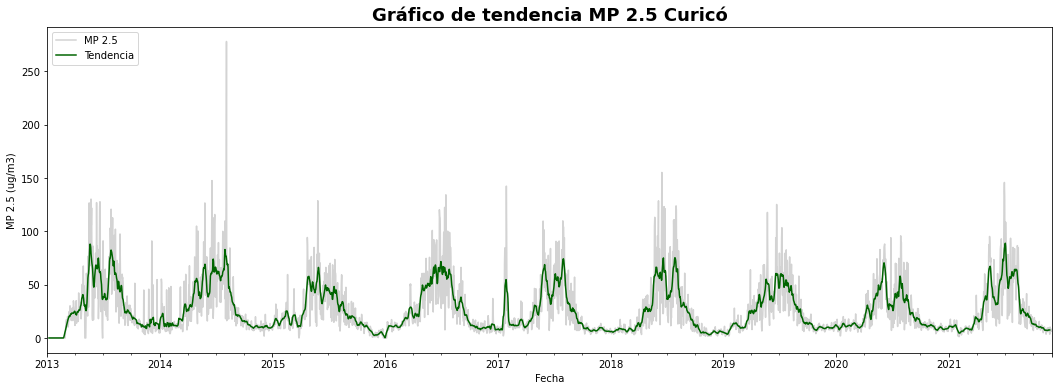

In [134]:
## ahora se realizan los gráficos uno a uno comenzando por la tendencia
fig, ax = plt.subplots(figsize=(18,6))
#grafico original
Datos3.plot(x="Fecha", y="Registros", ax=ax, label="MP 2.5", c='lightgrey')
#Grafico de la tendencia
trend.plot(ax=ax, label="Tendencia", color="darkgreen") ## si se fijan aquí se está utilizando el objeto 'trend'
plt.legend(loc='upper left')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico de tendencia MP 2.5 Curicó",fontdict={'weight': 'bold','size': 18})

plt.savefig('Images/Gráfico tendencia MP 2.5.png')

! pip install pymannkendall

#perform Mann-Kendall Trend Test
import pymannkendall as mk
Mann_Kendall=mk.original_test(Datos3.iloc[:,1])
print(Mann_Kendall)

print("\n Resultados\n Tendencia: " + Mann_Kendall.trend)

print(" P-value: " + str(Mann_Kendall.p))


### **Estacionalidad**

En cuanto a la estacionalidad, se considera una serie de tiempo es periódica si se repite a intervalos igualmente espaciados [8]. En este sentido en la gráfica de estacionalidad, se comienza a ver una cierta estacionalidad en los datos. 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



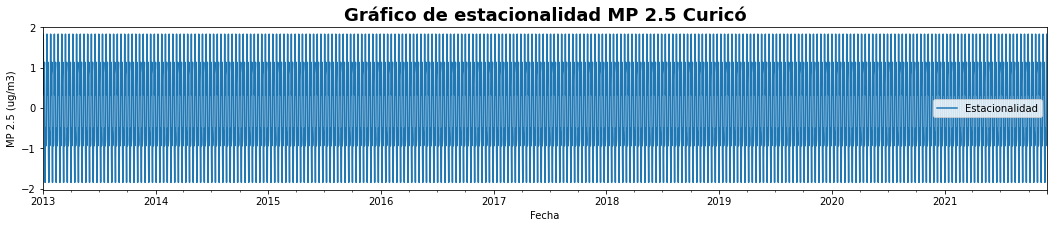

In [135]:
fig, ax = plt.subplots(figsize=(18,3)) ## aquí indicamos las proporciones del gráfico, que en este caso se hace un poco más delgados
seasonal.plot(ax=ax, label="Estacionalidad") # aquí se usa el objeto seasonal que se obtuvo los pasos anteriores
plt.legend(loc='bottom left')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico de estacionalidad MP 2.5 Curicó",fontdict={'weight': 'bold','size': 18})
plt.savefig('Images/Gráfico estacionalidad MP 2.5.png')



En este sentido al hacer un zoom en los datos y solo considerar un horizonte de planeación de seis meses, se puede apreciar una estacionalidad cada 15 días (dos ciclos por mes).



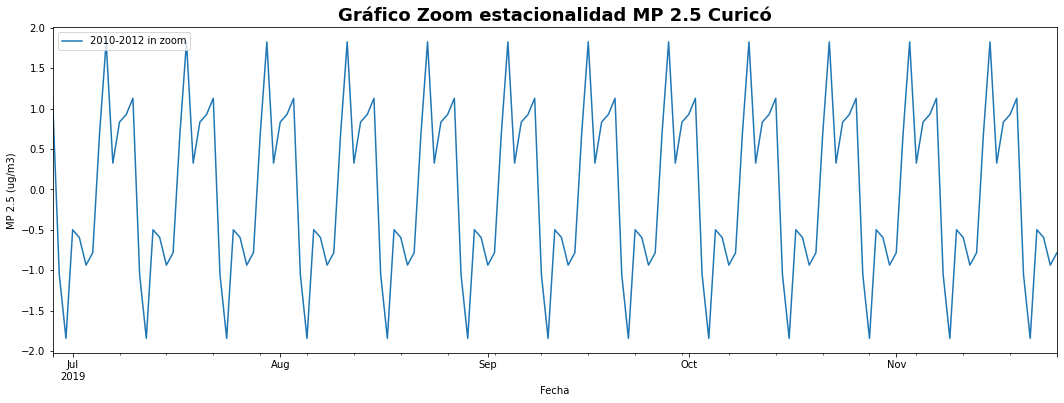

In [136]:

fig, ax = plt.subplots(figsize=(18,6))
zoom_range = Datos3[(Datos3.Fecha>= '2019-01-01') & (Datos3.Fecha< '2019-06-01')].index
seasonal[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom")
plt.legend(loc='upper left')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico Zoom estacionalidad MP 2.5 Curicó",fontdict={'weight': 'bold','size': 18})
plt.savefig('Images/Gráfico Zoom estacionalidad MP 2.5.png')

Para verificar la estacionalidad de los datos se usará la Prueba de Dickey-Fuller, considerando las siguientes hipótesis:






*   **Ho=** Los datos presentan root unitario, lo que significa que los datos no son estacionarios
*   **H1=** Los datos no presentan root unitario, lo que significa que los datos son estacionarios



El Test entrego valor de la estadística de prueba de -4.3. considerando que entre más negativa sea esta estadística, es más probable que rechacemos la hipótesis nula (Los datos serían estacionario). Además, el estadístico de -4.3 es menor que el valor de -3,5 al 1%.

Esto sugiere que se rechaza la hipótesis nula con un nivel de significancia de menos del 1% (es decir, una probabilidad baja de que el resultado sea una casualidad estadística). En resumen, la serie de datos es estacionaria y eso significa que no tiene una estructura dependiente del tiempo.


In [137]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(Datos3.iloc[:,1])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.306185
p-value: 0.000433
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


#### **Los residuos**

Los residuos del modelo se muestran poca aletoriedad, incluso es posible visualizar una estacionalidad, por tanto, sin necesidad de hacer un test estadístico. 



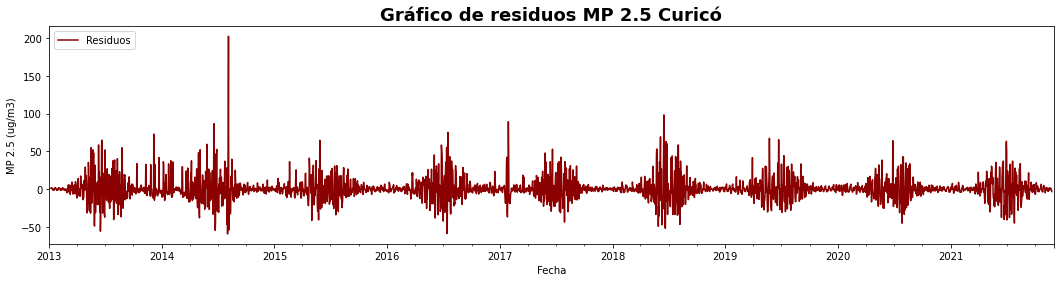

In [138]:
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality", color="darkred",label="Residuos") ## Y se utiliza el objeto residual que se obtuvo en la descomposición de la serie
plt.legend(loc='upper left')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico de residuos MP 2.5 Curicó",fontdict={'weight': 'bold','size': 18})

plt.savefig('Images/Gráfico residuos MP 2.5.png')


De todas formas, se analizará  el estadístico Durbin-Watson para evaluar la autocorrelación de los residuos. El valor es de 1.467, considerando que se usa solo una variable en este modelo el intervalo de confianza para este el resultado del test significa que los residuos tienen una correlación positiva.

In [139]:
from statsmodels.stats.stattools import durbin_watson
residual.fillna(0, inplace=True)

durbinWatson = durbin_watson(residual)
print('Durbin-Watson:', durbinWatson)


Durbin-Watson: 1.467398058222001


Generación de los datos de Entrenamiento y Prueba

En las siguientes líneas se divide la base de datos en datos de entrenamiento y datos de prueba

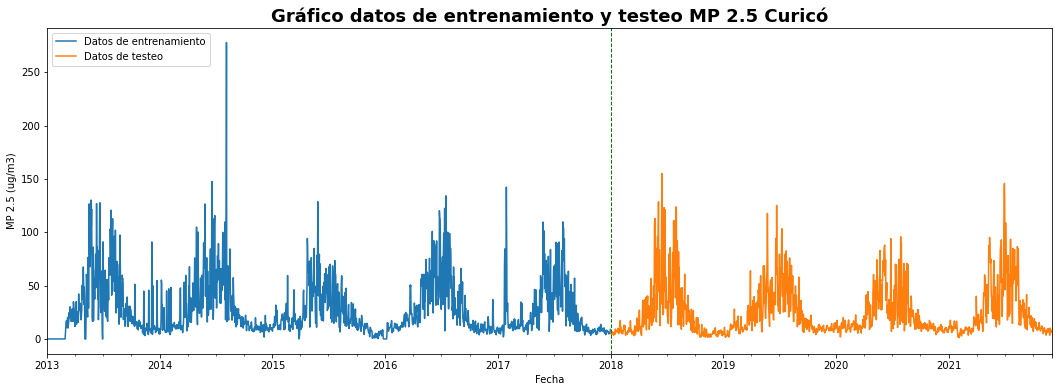

In [140]:
import numpy as np

#los datos de entrenamiento son del 2013 al 2017
train_range = Datos3[Datos3.Fecha < '2018-01-01'].index
#los datos de entrenamiento son del 2018 al 2021
test_range = Datos3[(Datos3.Fecha >= '2018-01-01')].index
fig, ax = plt.subplots(figsize=(18,6))

#Creación de los rangos de entrenamiento y prueba
Datos3.loc[train_range].plot(x="Fecha", y="Registros", ax=ax, label="Datos de entrenamiento")
Datos3.loc[test_range].plot(x="Fecha", y="Registros", ax=ax, label="Datos de testeo")

#Creaciónde la gráfica de los datos
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico datos de entrenamiento y testeo MP 2.5 Curicó",fontdict={'weight': 'bold','size': 18})
plt.savefig('Images/Gráfico Datos de entrenamiento y testeo MP 2.5.png')
plt.axvline(pd.to_datetime(str(Datos3.loc[test_range].Fecha.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')



### **Facebook Prophet Model**

A continuación, se presenta el modelo Prophet desarrollado para pronosticar datos de series de tiempo que ayuda a las empresas a comprender y posiblemente predecir el mercado [9]. Se centra en el modelo aditivo descomponible donde las tendencias no lineales se ajustan a la estacionalidad [9]. Está última característica presente en el set de datos del estudio, hace pensar que los resultados pueden ser de buena calidad. El Prophet es una herramienta de código abierto de Facebook utilizada [9].


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


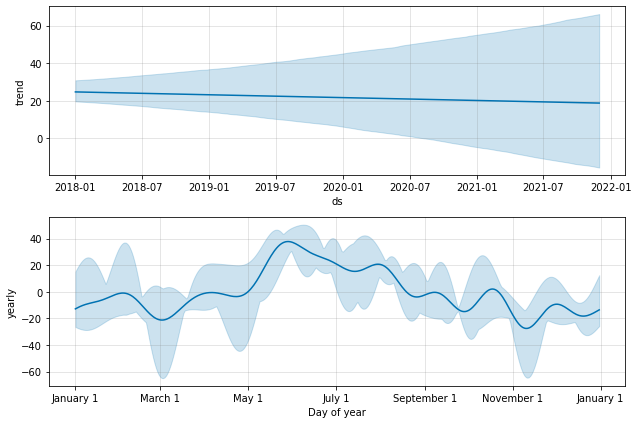

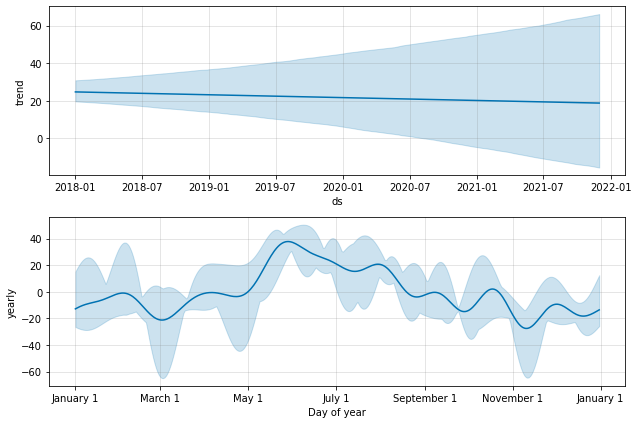

In [141]:
from fbprophet import Prophet

#Creación de base de datos de entrenamiento y prueba
Datos3_prophet_train = Datos3.loc[train_range][["Fecha", "Registros"]]
Datos3_prophet_train.columns = ["ds", "y"]

#Creación del modelo Prophet 
model = Prophet(
    yearly_seasonality=True, #verano aire mas limpio
    weekly_seasonality=False, #fds mas contaminados
    daily_seasonality=False, #menos contaminacion a las 15:00-14:00
    #changepoints=list(changepoints.keys()),
    #holidays=df_holidays,
    mcmc_samples=12, #jugar con este valor de frecuencia porque esto esta en 12 meses
    growth='linear',
    interval_width=0.9)

model.fit(Datos3_prophet_train);

#Generación de predicción en base al modelo Prophet 
Datos3_prophet_test = Datos3.loc[test_range][["Fecha", "Registros"]] 
Datos3_prophet_test.columns = ["ds", "y"]

#Generación del modelo de predicción e intervalo de confianza del mismo
forecast = model.predict(Datos3_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = Datos3.loc[test_range].Registros.values

#Creación del gráfico del modelo Prophet
model.plot_components(forecast)


El modelo obtenido muestra un ajuste medianamente bueno, pero creo que con otras técnicas se podría obtener un resultado mejor.


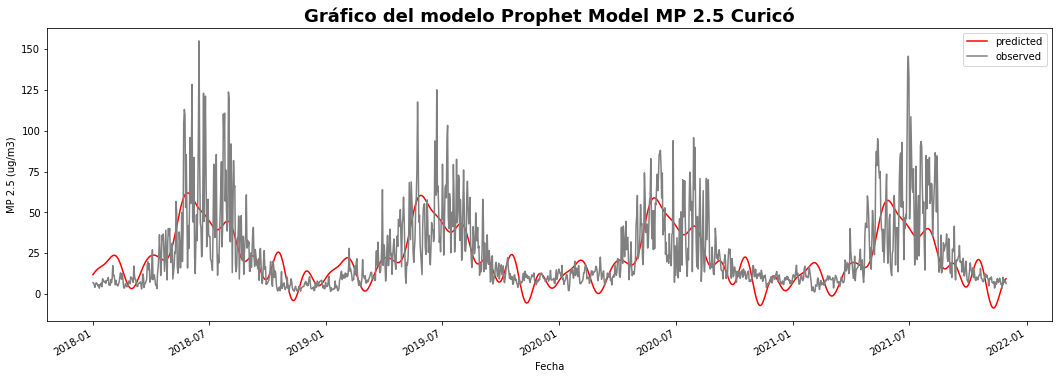

In [142]:
# Creación de la grafica del modelo Prophet y los datos reales
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(Datos3.loc[test_range].Fecha.values), yhat_test,
        color="red", label="predicted")

Datos3.loc[test_range].plot(x="Fecha", y="Registros", ax=ax, label="observed",color="grey")
plt.legend(loc='best')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico del modelo Prophet Model MP 2.5 Curicó",fontdict={'weight': 'bold','size': 18})

plt.savefig('Images/Gráfico del del modelo Prophet Model MP 2.5.png')

plt.show();

Al ver la grafíca con el intervalo de confianza, se puede ver que el intervalo obtenido es muy amplio. Esto reafirma el psotulado que la predicción obtenida es mejorable.

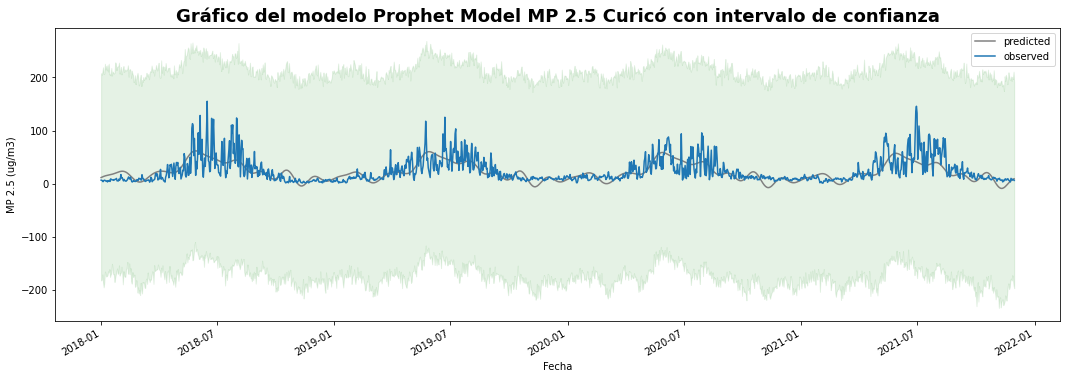

In [143]:
# Creación de la grafica del modelo Prophet y los datos reales con intervalo de confianza
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(Datos3.loc[test_range].Fecha.values), yhat_test,
        color="grey", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

Datos3.loc[test_range].plot(x="Fecha", y="Registros", ax=ax, label="observed")

plt.legend(loc='best')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico del modelo Prophet Model MP 2.5 Curicó con intervalo de confianza",fontdict={'weight': 'bold','size': 18})

plt.savefig('Images/Gráfico del del modelo Prophet Model MP 2.5 e intervalo de confianza.png')
plt.show();

Para terminar el análisis de resultados, se calculan cuatro métricas para evaluar la calidad de la predicción:

*   Error absoluto medio (MAE): es una medida de la diferencia entre la predicción y el valor observado relativos a un mismo fenómeno.  alternativa de medición.

*   Error cuadrático medio (MSE): Estimador mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima [10].
*   Coeficiente de determinación (R2): Estadístico usado en el contexto de un modelo estadístico cuyo principal propósito es predecir futuros resultados o probar una hipótesis [10].
*   Coeficiente de desigualdad de Theil (U): es una medida de desigualdad basada en la entropía de Shannon. Si U tiende a cero, el modelo puede ser utilizado para predecir dado que sus pronósticos serán fiables.  Si U tiende a uno, el modelo no sirve para predecir sus pronósticos no son reales [10].







In [144]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

def theils_u_metric(y_true, y_pred):

#Cálculo de las medidas de desempeño 
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))

    return np.sqrt(SS_res / (SS_true * SS_pred))

In [145]:
#Cálculo de las medidas de desempeño  
mape = mean_absolute_percentage_error(y_test, yhat_test)*100
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)

print("RESULTADOS MODELO PROPHET")
print("MAPE (test): {:0.0f}%".format(mape))
print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))




RESULTADOS MODELO PROPHET
MAPE (test): 80%
MAE (test): 12
MSE (test): 307
R2  (test): 0.437
U   (test): 0.018919


Con el propósito de evaluar los resultados obtenidos con el modelo PROPHET, compararemos los resultados con uno de los modelos de pronóstico simple, pero efectivo. Este tipo de modelos se ha usado anteriormente en problemas asociados a la contaminación ambiental [11-12].

RESULTADOS MODELO MEDIA MOVÍL ORDEN 3
MAPE (test): 29%
MAE (test): 6
MSE (test): 114
R2  (test): 0.791
U   (test): 0.029134
[[0.        ]
 [0.        ]
 [6.38888889]
 ...
 [8.02777778]
 [7.73611111]
 [7.52777778]]


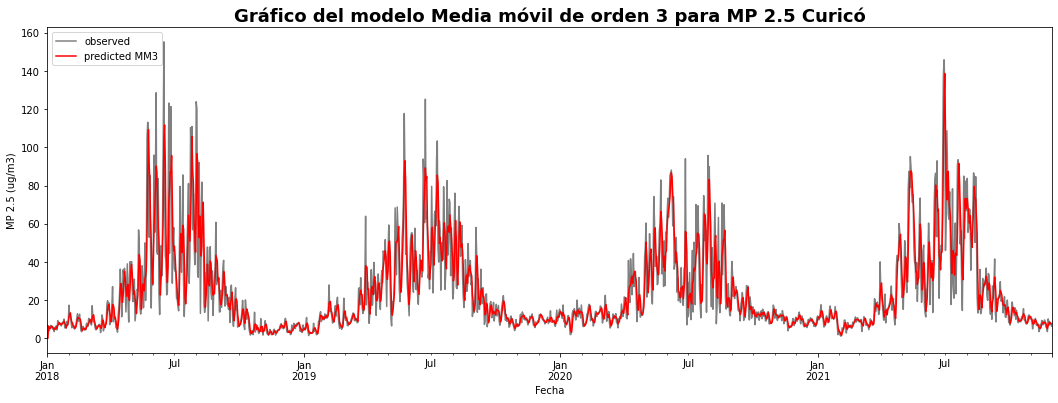

In [146]:
#Definición del modelo de media móvil de orden 3
y_MM=Datos3.loc[test_range].rolling(window =3).mean().fillna(0).values

#Calculo de las métricas de error
mape = mean_absolute_percentage_error(y_test, y_MM)*100
mae = mean_absolute_error(y_test, y_MM)
mse = mean_squared_error(y_test, y_MM)
r2 = r2_score(y_test, y_MM)
u = theils_u_metric(y_test, y_MM)

print("RESULTADOS MODELO MEDIA MOVÍL ORDEN 3")
print("MAPE (test): {:0.0f}%".format(mape))
print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

# Creación de la grafica del modelo de media móvil y los datos reales
MM=pd.DataFrame(y_MM)

MM.insert(0,"Fecha",Datos3.loc[test_range].Fecha.values)
MM.columns = ["Fecha", "Registros"]
fig, ax = plt.subplots(figsize=(18,6))

Datos3.loc[test_range].plot(x="Fecha", y="Registros", ax=ax, label="observed",color="grey")
test_range = MM[(MM.Fecha >= '2018-01-01')].index
MM.loc[test_range].plot(x="Fecha", y="Registros", ax=ax, label="predicted MM3",color="red")
ax.plot(pd.to_datetime(MM.loc[test_range].Fecha.values), y_MM)
plt.legend(loc='best')
plt.xlabel("Fecha")
plt.ylabel("MP 2.5 (ug/m3)")
plt.title("Gráfico del modelo Media móvil de orden 3 para MP 2.5 Curicó",fontdict={'weight': 'bold','size': 18})

plt.savefig('Images/Gráfico del del modelo media móvil de orden 3 MP 2.5.png')
print(y_MM)
plt.show();

Se puede apreciar que el modelo de media móvil presenta mejores indicadores, en comparación al modelo base. Con respecto a la gráfica, las curvas se solapan y ajustan de mucha mejor forma.

## **Conclusiones**
El análisis realizado al presente estudio exploratorio consistió principalmente en la revisión del material particulado (MP) 2.5 de Curicó establecido entre las fechas 07-07-2012 al 30-11-2021 por hora considerando el registro no validado, preliminar y oficiales.

Una de las acciones a realizar durante el estudio, fue la transformación de datos, los cuales debió de considerarse la suma de las tres columnas de registro de este. Una vez establecida esta acción es que se prosigue a imputar los datos faltantes y erróneos a partir de la media arrojada por la base de datos. 

Más tarde, en cuanto al área visual de esta investigación, es que se pudo apreciar que los datos obtenidos en la misma presentan una alta dispersión, como resultado se agruparan por día. Una vez establecida esta modificación es que se podrá apreciar una mejora sustancial en las gráficas, sin embargo, se eliminara el año 2012 puesto que en este se aprecian datos atípicos a lo requerido en el estudio. 

Por otra parte, el resultado obtenido del test Mann Kendal, se puede identificar la presencia de una tendencia de valor decreciente en los datos analizados, y como el p-value es menor a 5%, se rechaza la hipótesis establecida como nula por lo que como resultado no se puede asegurar la existencia de una tendencia de carácter decreciente en los datos. En cuanto a los resultados de la estacionariedad obtenidos en test Dickey-Fuller, la serie de datos se presenta como estacionaria y eso se traduce como que este no presenta una estructura dependiente del tiempo. Finalmente se evidencia que los residuos no se presentan de manera aleatoria sin embargo con correlación positiva.

Finalmente, el modelo Prophet utilizado para modelar y predecir las series temporales vistas en esta investigación, nos presenta gráficamente un resultado con un intervalo de confianza muy amplio por lo que al comparar los resultados con un modelo de media móvil de orden 3, este ultimo modelo presenta mejores resultados puesto que en esta base de datos existía una dependencia sustantiva con los datos anteriores.   

Como futuras investigaciones en esta línea de trabajo, se propone experimentar con algoritmos autorregresivos ARIMA u otros métodos vistos, puesto que entregan una regresión en base a datos históricos.
Para futuras investigaciones se propone probar con algoritmos autoagresivos ARIMA u otros métodos vistos.


## Referencias

[1] Delgado, M., Sánchez, D., & Zapata, S. (2004). Sistema de Soporte de Decisiones: Aplicación a la Gestión de la Contaminación en la ciudad de Santiago de Chile. In XII Congreso Español Sobre Tecnologías y Lógica Fuzzy. Universidad de Granada Universidad de Granada. U. Tecnológica Metropolitana.
[Link](https://ccia.ugr.es/~castro/docto-csi/SZC/p45.pdf)

[2] Reyes Saldaña, J. F., & García Flores, R. (2005). El proceso de descubrimiento de conocimiento en bases de datos. Ingenierías, 8(26), 37-47.

[3] Agrawal R, Srikant R. Fast algorithms for mining association rules. In: VLDB Conference. Santiago de Chile, Chile; 1994. 14. Chen M, Han J, Yu P. Data mining: An overview from database perspective. In: Journal IEEE Transactions on Knowledge Data Engineering. ISNN:1041-4347. New Jersey, USA; Vol.8(6); 1996:866-883.

[4] Aguila, Y. P., & Segredo, Y. F. (2015). Aplicación de técnicas de descubrimiento de conocimientos en el proceso de caracterización estudiantil. Ciencias de la Información, 46(3), 25-30.

[5] Pereira, R. T., & Chamorro, M. C. Y. La minería de datos aplicada al descubrimiento de patrones de supervivencia en mujeres con cáncer invasivo de cuello uterino.


[6] Sistema Nacional de la Calidad del aire, (s.f.). Objetivos de SINCA, [Link ](https://sinca.mma.gob.cl/index.php/pagina)


[7] Sistema Nacional de la Calidad del aire, (s.f.). Estación Curicó, [Link](https://sinca.mma.gob.cl/index.php/estacion/index/key/709)

[8] Villavicencio, J. (2010). Introducción a series de tiempo. Puerto Rico.

[9] Rafferty, G., Getting Started with Facebook Prophet, [Link](https://towardsdatascience.com/getting-started-with-facebook-prophet-20eccb25b06b)

[10] Imbens, G. W., Newey, W. K., & Ridder, G. (2005). Mean-square-error calculations for average treatment effects.

[11] Castro, P., Vera, J., Cifuentes, L., Wellenius, G., Verdejo, H., Sepúlveda, L., ... & Llevaneras, S. (2010). Polución por material particulado fino (PM 2, 5) incrementa las hospitalizaciones por insuficiencia cardiaca. Revista chilena de cardiología, 29(3), 306-314.

[12] Méndez Caicedo, M. (2004). Análisis de intervención-efectividad de las políticas para reducción de la contaminación por fuentes móviles en Bogotá (Master's thesis, Uniandes).